In [2]:
import numpy as np
import pandas as pd

In [3]:
df_train = pd.read_csv("train.csv", index_col=False)
df_valid = pd.read_csv("valid.csv", index_col = False)
df_test = pd.read_csv("test.csv", index_col = False)

In [88]:
# df_train = pd.concat([df_train, df_valid])

In [4]:
df_train['Age'] = (df_train['Age']-df_train['Age'].mean())/df_train['Age'].std()
df_valid['Age'] = (df_valid['Age']-df_valid['Age'].mean())/df_valid['Age'].std()
df_test['Age'] = (df_test['Age']-df_test['Age'].mean())/df_test['Age'].std()

In [5]:
y_train = df_train['FraudFound_P']
x_train = df_train.drop('FraudFound_P',axis = 1)
y_valid = df_valid['FraudFound_P']
x_valid = df_valid.drop('FraudFound_P',axis = 1)
y_test = df_test['FraudFound_P']
x_test = df_test.drop('FraudFound_P',axis = 1)

In [6]:
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)

x_train, y_train = smote_enn.fit_resample(x_train, y_train)

In [92]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [93]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 4012,
        class_weight = class_weight
        )
    return model
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    return round(metrics.fbeta_score(y, y_pred, beta = 0.75), 3)
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

In [94]:
# %pip install optuna
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200, timeout = 600)


[I 2022-11-12 19:38:46,638] A new study created in memory with name: no-name-cc68b213-3234-4922-992a-2463b3ac9932
[I 2022-11-12 19:38:46,829] Trial 0 finished with value: 0.186 and parameters: {'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 17, 'zero_weight': 0.9816032861923679}. Best is trial 0 with value: 0.186.
[I 2022-11-12 19:38:46,967] Trial 1 finished with value: 0.199 and parameters: {'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 15, 'zero_weight': 0.4480329602277252}. Best is trial 1 with value: 0.199.
[I 2022-11-12 19:38:47,125] Trial 2 finished with value: 0.202 and parameters: {'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 5, 'zero_weight': 0.6869450722754292}. Best is trial 2 with value: 0.202.
[I 2022-11-12 19:38:47,353] Trial 3 finished with value: 0.2 and parameters: {'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 10, 'zero_weight': 0.41318674180691806}. Best is trial 2 with value: 0.202.
[I 2022-11-12 19:38:47,5

In [95]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
print("Best Fbeta Score: ", model_performance(best_model))

Best Fbeta Score:  0.297


In [96]:
y_pred = best_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))
metrics.fbeta_score(y_test,y_pred, beta = 0.75)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2131
           1       0.21      0.25      0.23       134

    accuracy                           0.90      2265
   macro avg       0.58      0.60      0.59      2265
weighted avg       0.91      0.90      0.90      2265



0.22380200105318587

In [97]:
study.best_trial.params

{'max_depth': 28,
 'min_samples_split': 8,
 'min_samples_leaf': 10,
 'zero_weight': 0.7818546548914952}

In [98]:
feature_impt = pd.DataFrame({'feature name':best_model.feature_names_in_, 'feature importance':best_model.feature_importances_})
not_impt = feature_impt[feature_impt['feature importance'] == 0]
print(not_impt)

                      feature name  feature importance
6                Days_Policy_Claim                 0.0
17         PoliceReportFiled_IsYes                 0.0
18            WitnessPresent_IsYes                 0.0
22                        Make_BMW                 0.0
24                      Make_Dodge                 0.0
25                    Make_Ferrari                 0.0
28                     Make_Jaguar                 0.0
29                      Make_Lexus                 0.0
31                    Make_Mecedes                 0.0
32                    Make_Mercury                 0.0
33                     Make_Nisson                 0.0
35                     Make_Porche                 0.0
36                       Make_Saab                 0.0
37                     Make_Saturn                 0.0
39                         Make_VW                 0.0
40          MaritalStatus_Divorced                 0.0
43             MaritalStatus_Widow                 0.0
47   Polic

Variables
PolicyType_Sedan - Liability       0.141784
Fault_IsPolicyholder               0.139743
VehiclePrice                       0.097409
Year                               0.093742
MonthClaimed                       0.086447
PolicyType_Sedan - Collision       0.079994
Deductible                         0.068993
PolicyType_Sedan - All Perils      0.048570
AgeOfVehicle                       0.037707
PolicyType_Utility - All Perils    0.031153
Name: Importance, dtype: float64


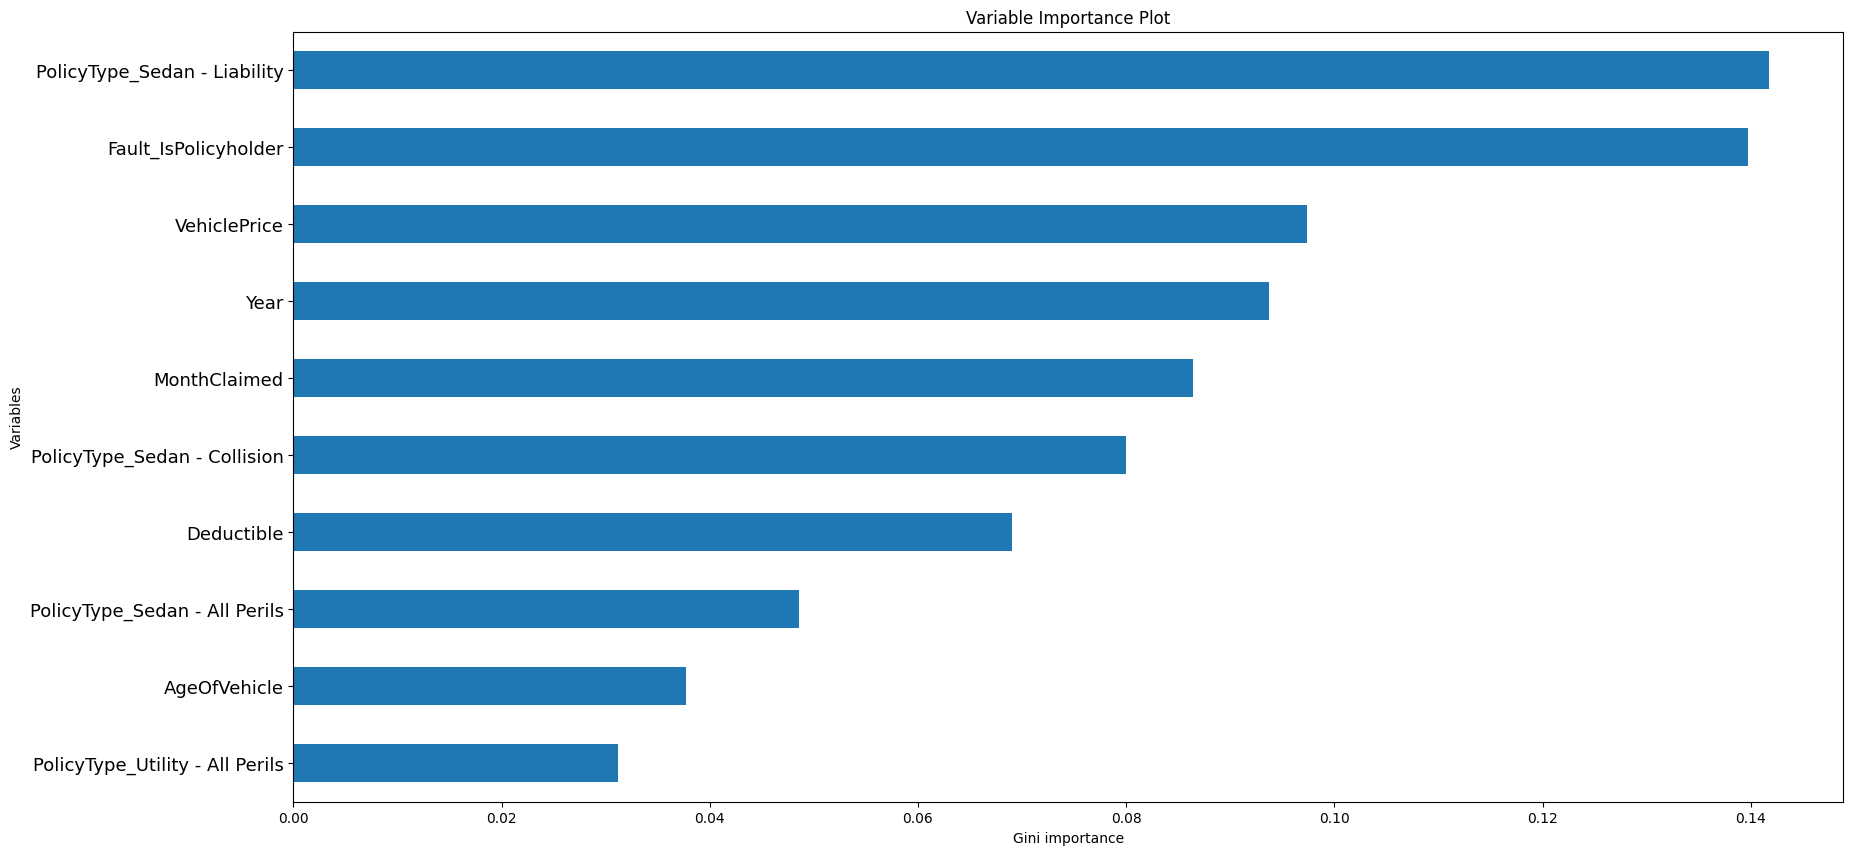

In [99]:
import matplotlib.pyplot as plt
model_ranks = pd.Series(best_model.feature_importances_, index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:10].sort_values(ascending=True, inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
ax.set_title('Variable Importance Plot')
ax.set_xlabel('Gini importance')
ax.set_yticklabels(top_features.index, fontsize=13)

print(top_features.sort_values(ascending=False))

In [100]:
# remove feature importance == 0
not_impt['feature name']
x_train = x_train.drop(not_impt['feature name'], axis = 1)
x_valid = x_valid.drop(not_impt['feature name'], axis = 1)
x_test = x_test.drop(not_impt['feature name'], axis = 1)

In [101]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 4012,
        class_weight = class_weight
        )
    return model
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    return round(metrics.fbeta_score(y, y_pred, beta = 0.75), 3)
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

In [102]:
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200, timeout = 600)

[I 2022-11-12 19:40:46,794] A new study created in memory with name: no-name-3cff7210-2cae-4271-8a06-26e8b9c97533
[I 2022-11-12 19:40:46,962] Trial 0 finished with value: 0.199 and parameters: {'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 9, 'zero_weight': 0.24371290186839056}. Best is trial 0 with value: 0.199.
[I 2022-11-12 19:40:47,111] Trial 1 finished with value: 0.212 and parameters: {'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 16, 'zero_weight': 0.2820643286894907}. Best is trial 1 with value: 0.212.
[I 2022-11-12 19:40:47,244] Trial 2 finished with value: 0.198 and parameters: {'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 16, 'zero_weight': 0.20533197296654593}. Best is trial 1 with value: 0.212.
[I 2022-11-12 19:40:47,364] Trial 3 finished with value: 0.2 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'zero_weight': 0.4284240932835538}. Best is trial 1 with value: 0.212.
[I 2022-11-12 19:40:47,

In [103]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))
metrics.fbeta_score(y_test,y_pred, beta = 0.75)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2131
           1       0.28      0.18      0.22       134

    accuracy                           0.92      2265
   macro avg       0.62      0.58      0.59      2265
weighted avg       0.91      0.92      0.92      2265



0.23382696804364772

some improvement in performance after feature selection

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def create_model(trial):
    leaf_size = trial.suggest_int("leaf_size", 1, 50)
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    p = trial.suggest_int("p",1,2)
    model = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors, p = p)
    return model
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    return round(metrics.fbeta_score(y, y_pred, beta = 0.75), 3)
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)


In [10]:
# %pip install optuna
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200, timeout = 600)



[I 2022-11-12 20:13:58,758] A new study created in memory with name: no-name-f798657b-a2e7-465b-a4b8-1a1d66e7d4c4
[I 2022-11-12 20:13:59,842] Trial 0 finished with value: 0.174 and parameters: {'leaf_size': 17, 'n_neighbors': 2, 'p': 1}. Best is trial 0 with value: 0.174.
[I 2022-11-12 20:14:00,414] Trial 1 finished with value: 0.131 and parameters: {'leaf_size': 40, 'n_neighbors': 16, 'p': 2}. Best is trial 0 with value: 0.174.
[I 2022-11-12 20:14:00,873] Trial 2 finished with value: 0.126 and parameters: {'leaf_size': 7, 'n_neighbors': 25, 'p': 2}. Best is trial 0 with value: 0.174.
[I 2022-11-12 20:14:01,239] Trial 3 finished with value: 0.138 and parameters: {'leaf_size': 47, 'n_neighbors': 1, 'p': 2}. Best is trial 0 with value: 0.174.
[I 2022-11-12 20:14:01,622] Trial 4 finished with value: 0.134 and parameters: {'leaf_size': 23, 'n_neighbors': 22, 'p': 2}. Best is trial 0 with value: 0.174.
[I 2022-11-12 20:14:02,372] Trial 5 finished with value: 0.153 and parameters: {'leaf_siz

In [11]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print(metrics.classification_report(y_test,y_pred))
print(metrics.fbeta_score(y_test,y_pred, beta = 0.75))
print(study.best_trial.params)

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      2131
           1       0.13      0.49      0.21       134

    accuracy                           0.78      2265
   macro avg       0.55      0.64      0.54      2265
weighted avg       0.91      0.78      0.83      2265

0.17900418594404055
{'leaf_size': 4, 'n_neighbors': 6, 'p': 1}


In [12]:
knn = best_model

In [13]:
import shap
# Initialize model
f = lambda x: knn.predict_proba(x)[:,1]
med = x_train.median().values.reshape((1,x_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(x_test.iloc[0:1000,:])

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with fe

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


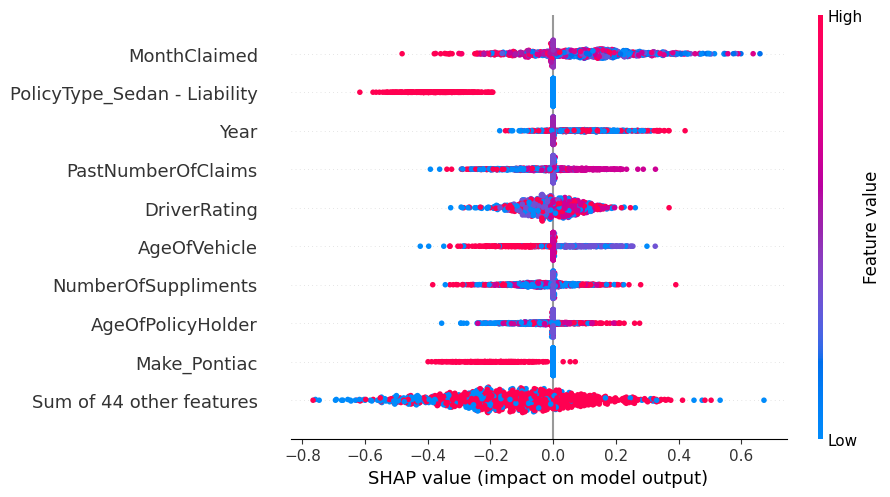

In [14]:
shap.plots.beeswarm(shap_values)

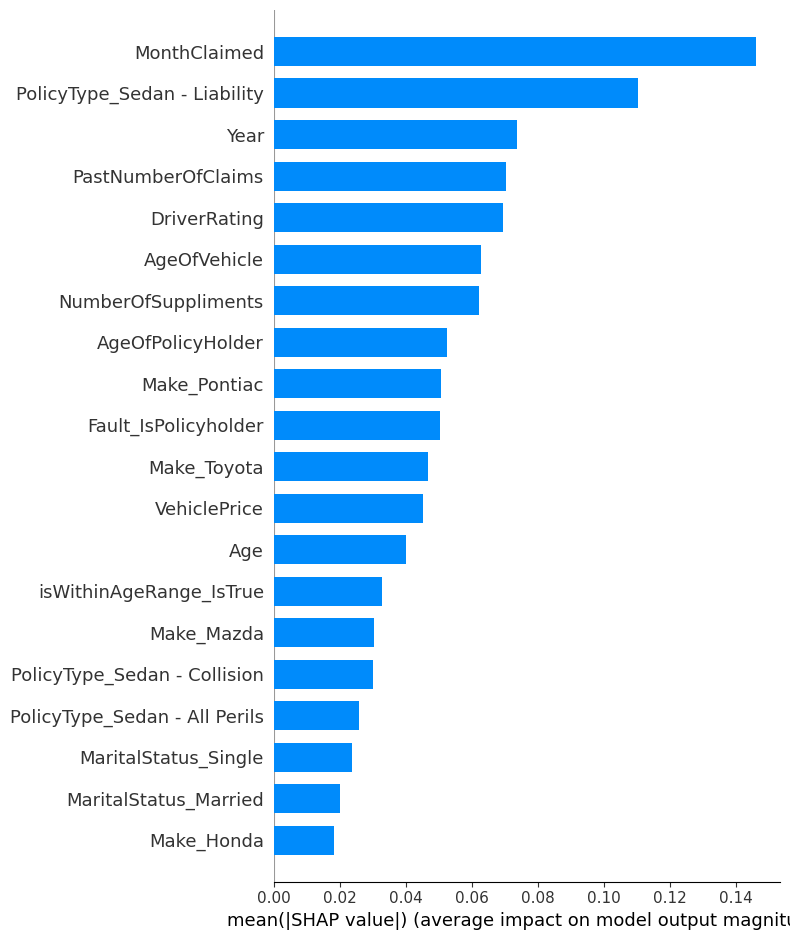

In [16]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = x_train.columns)

## GaussianNB

In [28]:
from sklearn.naive_bayes import GaussianNB
bn = GaussianNB()
bn.fit(x_train, y_train)
print(metrics.classification_report(y_test, bn.predict(x_test)))
print(metrics.fbeta_score(y_test, bn.predict(x_test), beta = 0.75))
print(metrics.recall_score(y_test, bn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.28      0.44      2131
           1       0.07      0.93      0.14       134

    accuracy                           0.32      2265
   macro avg       0.53      0.60      0.29      2265
weighted avg       0.93      0.32      0.42      2265

0.11184068114582581
0.9253731343283582
